In [1]:
import matplotlib.pyplot as plt
import numpy as np

import sklearn
from sklearn.mixture import GaussianMixture

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import jax
import jax.numpy as jnp
from jax import jit, vmap
from jax.nn import sigmoid

import time

In [2]:
jax.devices()

[GpuDevice(id=0, process_index=0)]

In [3]:
EPS = 1e-10
fontsize=13

In [4]:
import sys
sys.path.append('../')
import adaprobe

# Vary number of stimuli

In [5]:
test_Ns = [2, 4, 8, 16, 32, 64]
test_num_targets = [1, 2, 4, 8, 16, 32, 64]
test_Ks = [500, 1000, 2000, 4000]
test_sigmas = [1, 3, 5]

In [6]:
fit_options = {
    'iters': 100,
    'num_mc_samples': 20
}

In [7]:
# sigma = 1
# K = 500
powers = np.arange(10, 51, 10)
a = 0.5
num_repeats = 20


for sigma in test_sigmas:
    for K in test_Ks:

        error_matrix = -1 * np.ones((len(test_Ns), len(test_num_targets), num_repeats))

        tstart = time.time()
        for idxn, N in enumerate(test_Ns):
            for idxs, num_targets in enumerate(test_num_targets):
                if num_targets > N:
                    continue
                for rep in range(num_repeats):
                    print('pop size: %i,  num_targets: %i,  run: %i\t'%(N, num_targets, rep), end='\r')

                    # generate simulation
                    phi_1 = np.random.uniform(2.5, 5.5, N)
                    sim = adaprobe.Simulation3d(N=N, phi_1=phi_1, a=a, sigma=sigma)
                    sim.simulate_multistim(trials=K, num_targets=np.min([num_targets, N]), powers=powers)

                    # configure priors
                    phi_prior = np.c_[0.1 * np.ones(N), 5 * np.ones(N)]
                    phi_cov_prior = np.array([np.array([[1e-1, 0], [0, 1e0]]) for _ in range(N)])
                    beta_prior = 7e0 * np.ones(N)
                    mu_prior = np.zeros(N)

                    priors = {
                        'beta': beta_prior,
                        'mu': mu_prior,
                        'phi': phi_prior,
                        'phi_cov': phi_cov_prior
                    }

                    stimulus_matrix = np.zeros((N, K))
                    for n in range(N):
                        locs = np.where(sim.tars == n)[0]
                        stimulus_matrix[n, locs] = sim.I[locs]

                    model = adaprobe.Model(sim.cell_locs, priors=priors)
                    model.fit(sim.y, stimulus_matrix, fit_options=fit_options, method='cavi_offline_spike_and_slab_NOTS_jax')

                    error_matrix[idxn, idxs, rep] = np.mean(np.abs(sim.w - model.state['mu'] * model.state['alpha']))
        tend = time.time()
        np.save('multispot_mapping_error_matrix_K%i_sigma%.1f.npy'%(K, sigma), error_matrix)
        print('\nTotal elapsed time %.2f min'%((tend-tstart)/60))

pop size: 64,  num_targets: 64,  run: 19	
Total elapsed time 14.55 min
pop size: 64,  num_targets: 64,  run: 19	
Total elapsed time 14.85 min
pop size: 64,  num_targets: 64,  run: 19	
Total elapsed time 16.43 min
pop size: 64,  num_targets: 64,  run: 19	
Total elapsed time 19.19 min
pop size: 64,  num_targets: 64,  run: 19	
Total elapsed time 13.75 min
pop size: 64,  num_targets: 64,  run: 19	
Total elapsed time 14.13 min
pop size: 64,  num_targets: 64,  run: 19	
Total elapsed time 15.88 min
pop size: 64,  num_targets: 64,  run: 19	
Total elapsed time 18.52 min
pop size: 64,  num_targets: 64,  run: 19	
Total elapsed time 14.01 min
pop size: 64,  num_targets: 64,  run: 19	
Total elapsed time 14.29 min
pop size: 64,  num_targets: 64,  run: 19	
Total elapsed time 16.31 min
pop size: 64,  num_targets: 64,  run: 19	
Total elapsed time 18.62 min


In [8]:
means = np.mean(error_matrix, axis=-1)
sdevs = np.std(error_matrix, axis=-1)

fontsize=13

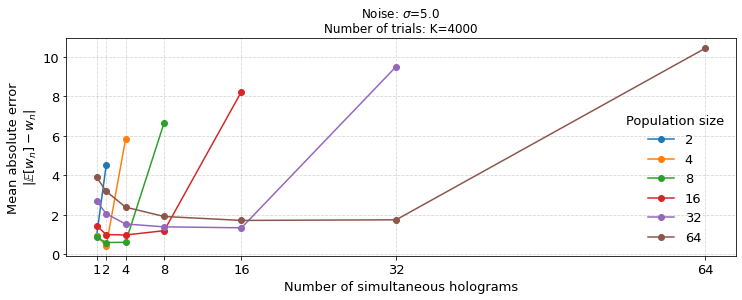

In [13]:
plt.figure(figsize=(12, 4))
for N in range(len(test_Ns)):
    num_pts = len(np.where(means[N] > -1)[0])
    plt.plot(test_num_targets[:num_pts], means[N][:num_pts], 'o-', color='C%i'%N)
#     plt.fill_between(num_targets_all[:num_pts], means[N][:num_pts] - sdevs[N][:num_pts], means[N][:num_pts] + sdevs[N][:num_pts], facecolor='C%i'%N, edgecolor='None', alpha=0.2)
plt.xticks(test_num_targets)
plt.legend(test_Ns, frameon=False, title='Population size', fontsize=fontsize, title_fontsize=fontsize)
plt.ylabel('Mean absolute error\n$|\mathbb{E}[w_n] - w_n|$', fontsize=fontsize)
plt.xlabel('Number of simultaneous holograms', fontsize=fontsize)
plt.title('Noise: $\sigma$=%.1f\nNumber of trials: K=%i'%(sigma, K))
plt.grid(linestyle='--', alpha=0.5)
# for loc in ['top', 'right']:
#     plt.gca().spines[loc].set_visible(False)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

# plt.savefig('figs/multi_spot_mapping_offline_err_vs_nstim_K%i_with_errbars.png'%K, format='png', bbox_inches='tight', dpi=200, facecolor='white')
plt.show()